## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import matplotlib.pyplot as plt

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

In [2]:
engine = create_engine("sqlite:///resources/hawaii.sqlite", echo=False)

In [3]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
for c in Base.classes: 
    print(c)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [6]:
Station = Base.classes.station
Measurement = Base.classes.measurement

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.
* Select only the `date` and `prcp` values.

In [7]:
session = Session(engine)

In [8]:
prcp = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date>'2016-08-23').group_by(Measurement.date)

* Load the query results into a Pandas DataFrame and set the index to the date column.

In [9]:
prcp_df = pd.read_sql(prcp.statement,session.bind)
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df = prcp_df.set_index('date')

* Plot the results using the DataFrame `plot` method.

`<center><img src='images/precip.png' /></center>`

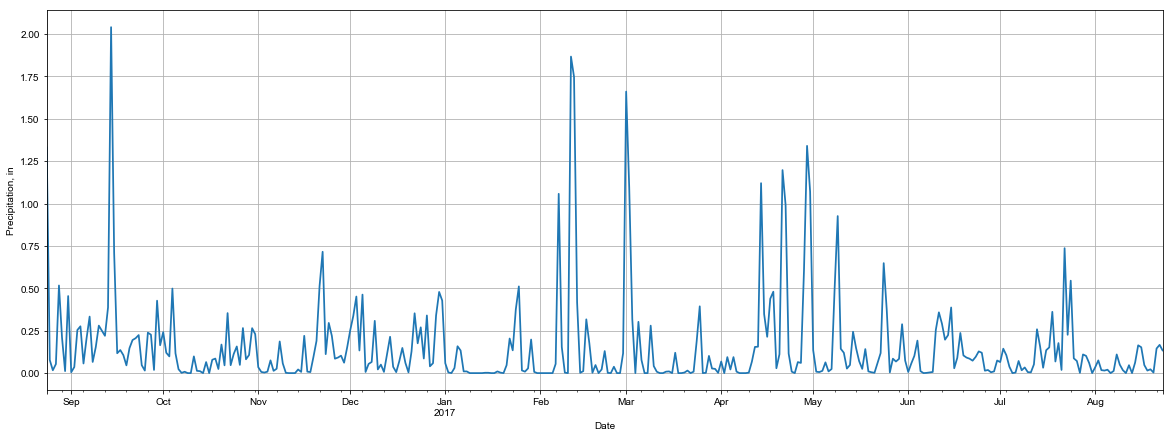

In [10]:
f, ax = plt.subplots(figsize=(20,7))
plt.style.use('seaborn')
prcp_df.plot(ax=ax,legend=False)
plt.xlabel('Date')
plt.ylabel('Precipitation, in')
ax.set_xlim([prcp_df.index.min(),prcp_df.index.max()])
plt.show()

* Use Pandas to print the summary statistics for the precipitation data.

In [11]:
prcp_df.describe()

,avg_1
count,365.000000
mean,0.156103
std,0.275657
min,0.000000
25%,0.008571
50%,0.065000
75%,0.175714
max,2.040000


### Station Analysis

* Design a query to calculate the total number of stations.

In [12]:
number_of_stations = session.query(Station.name).distinct().count()

print(f'There are {number_of_stations} stations')

There are 9 stations


* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

In [13]:
most_active_stations = session.query(Measurement.station, func.count(Measurement.prcp))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.prcp).desc()).all()
df = pd.DataFrame(most_active_stations,columns=['Station','Number of observations'])
df

,Station,Number of observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.

In [14]:
tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date>'2016-08-23', Measurement.station == 'USC00519281').group_by(Measurement.date)

In [16]:
tobs_df = pd.read_sql(tobs.statement,session.bind)
tobs_df['date'] = pd.to_datetime(tobs_df['date'])
tobs_df = tobs_df.set_index('date')
tobs_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


  * Plot the results as a histogram with `bins=12`.

 ` <center><img src='images/temp_hist.png' height="400px" /></center>`

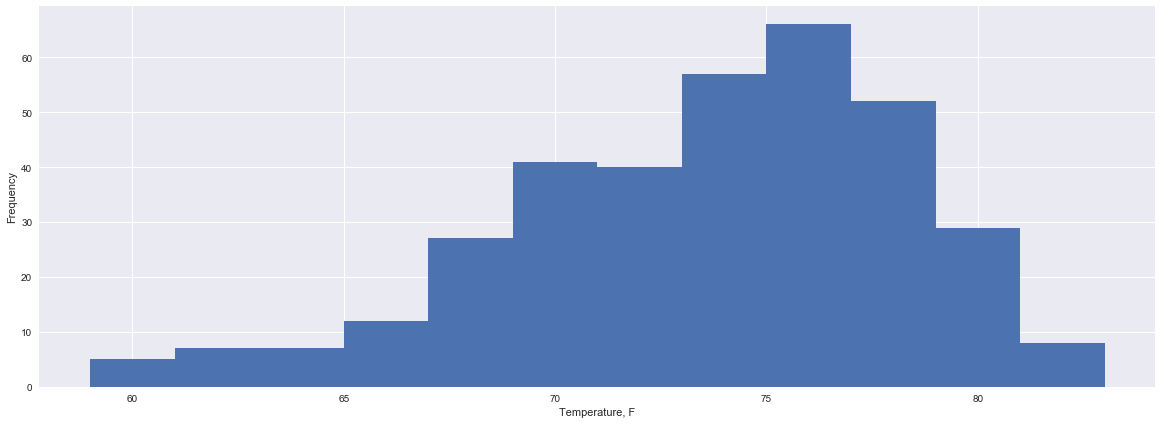

In [33]:
f, ax = plt.subplots(figsize=(20,7))
plt.style.use('seaborn')
tobs_df.plot(kind='hist',ax=ax,legend=False, bins=12)
plt.xlabel('Temperature, F')
plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

In [23]:
def calc_temps(start_date, end_date):
    min_temp = session.query(func.min(Measurement.tobs).label('name')).\
        filter(Measurement.date>start_date, Measurement.date<end_date).all()
    max_temp = session.query(func.max(Measurement.tobs).label('name')).\
        filter(Measurement.date>start_date, Measurement.date<end_date).all()
    avg_temp = session.query(func.avg(Measurement.tobs).label('name')).\
        filter(Measurement.date>start_date, Measurement.date<end_date).all()
    return min_temp[0].name, max_temp[0].name, avg_temp[0].name

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

In [24]:
vacation_start = '2018-08-15'
vacation_end   = '2018-08-30'

In [30]:
start_date, end_date = '2017-08-15','2017-08-30'
mn, mx, av = calc_temps(start_date, end_date)
print(f'Temperatures for {start_date}:{end_date} is:')
print(f'Min: {mn}, max: {mx}, average: {round(av,2)}')

Temperatures for 2017-08-15:2017-08-30 is:
Min: 71.0, max: 85.0, average: 78.73


* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='images/temp_avg.png' height="400px"/></center>

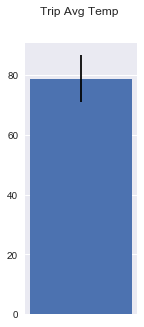

In [59]:
import numpy as np
f, ax = plt.subplots(figsize=(2,5))
plt.style.use('seaborn')
yerr=np.array([(av-mn,mx-av)])
plt.bar(1,av,yerr=yerr,width=0.5)
plt.suptitle('Trip Avg Temp')
plt.set_y
ax.get_xaxis().set_visible(False)
plt.show()

### Optional Recommended Analysis

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

  * Calcualte the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

  * Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

  <center><img src="images/daily_normals.png" /></center>

---

## Step 4 - Climate App

Now that you have completed your initial analysis, design a Flask api based on the queries that you have just developed.

* Use FLASK to create your routes.

### Routes

* `/api/v1.0/precipitation`

  * Query for the dates and temperature observations from the last year.

  * Convert the query results to a Dictionary using `date` as the key and `tobs` as the value.

  * Return the json representation of your dictionary.

* `/api/v1.0/stations`

  * Return a json list of stations from the dataset.

* `/api/v1.0/tobs`

  * Return a json list of Temperature Observations (tobs) for the previous year

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a json list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Hints

* You will need to join the station and measurement tables for some of the analysis queries.

* Use Flask `jsonify` to convert your api data into a valid json response object.